# Evaluate CTGAN on eICU cardiorespiratory past history data

In [ ]:
#!pip install sdv

In [158]:
import os
import numpy as np
import pandas as pd
import sys
import ctgan
from ctgan import CTGANSynthesizer
#from ctgan import load_demo

# hide warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
os.getcwd()

In [ ]:
# create the reverse one hot encoded data
"""
# load the CTGAN demo data
data = pd.read_csv('examples\csv\patients_allpasthistory_onehot_cardiorespiratory.csv')
data.columns

os.chdir('../eICU_gan/dataprep')
#os.getcwd()

from create_eICU_data import reverse_one_hot

os.chdir('../../CTGAN_Distribution')
#os.getcwd()

new_df = reverse_one_hot(data, columns=['ethnicity_AfricanAmerican',
       'ethnicity_Asian', 'ethnicity_Caucasian', 'ethnicity_Hispanic',
       'ethnicity_NativeAmerican', 'ethnicity_Other/Unknown'], prefix='ethnicity_', new_col='ethnicity')
#new_df.head()

new_df = reverse_one_hot(new_df, columns=['gender_Female','gender_Male'], prefix='gender_', new_col='gender')

new_df = reverse_one_hot(new_df, columns=['dischargestatus_Alive', 'dischargestatus_Expired'], prefix='dischargestatus_', new_col='dischargestatus')

#new_df.head()

print(new_df.columns)
# set the names of the demo data columns that are discrete

# save the eICU data without one hot encoded values so we can re-use it
new_df.to_csv('examples/csv/patients_cardiorespiratory_textcats.csv', index=False)
"""

In [2]:
new_df = pd.read_csv('examples/csv/patients_cardiorespiratory_textcats.csv')

In [ ]:
new_df.columns

In [3]:
discrete_columns = [
    'CHF', 'COPD_moderate',
       'COPD_nolimitations', 'COPD_severe', 'NoHealthProblems', 'asthma',
       'homeoxygen', 'hypertensionrequiringtreatment',
       'restrictivepulmonarydisease', 'All', 'ethnicity', 'gender',
       'dischargestatus'
]

In [4]:
# create the dataframe format and csv file to save evaluations of the CTGAN
# columns will be number epoch, generator loss, discriminator loss, number of generated samples, 
# CSTest Value ours vs real, KSTest Value ours vs real, 
# CSTest Value real train/test, KSTest Value real train/test,
# MulticlassDecisionTreeClassifier for COPD_severe, MulticlassMLPClassifier for COPD_severe, 
# MulticlassDecisionTreeClassifier for CHF, MulticlassMLPClassifier for CHF
# MulticlassDecisionTreeClassifier for dischargestatus, MulticlassMLPClassifier for dischargestatus
# MulticlassDecisionTreeClassifier for COPD_severe, MulticlassMLPClassifier for COPD_severe - real train/test split, 
# MulticlassDecisionTreeClassifier for CHF, MulticlassMLPClassifier for CHF - real train/test split, 
# MulticlassDecisionTreeClassifier for dischargestatus, MulticlassMLPClassifier for dischargestatus - real train/test split, 

df_CTGAN_eval = pd.DataFrame(columns=['epochs', 'time', 'distributed', 'num_generated_samples', 
'CSTest_Value_ours_v_real', 'KSTest_Value_ours_v_real', 'CSTest_Value_real_train_test', 'KSTest_Value_real_train_test',
'COPD_severe_MulticlassDecisionTreeClassifier', 'COPD_severe_MulticlassMLPClassifier', 
'CHF_MulticlassDecisionTreeClassifier', 'CHF_MulticlassMLPClassifier', 
'NoHealthProblems_MulticlassDecisionTreeClassifier', 'NoHealthProblems_MulticlassMLPClassifier', 
'dischargestatus_MulticlassDecisionTreeClassifier', 'dischargestatus_MulticlassMLPClassifier',
'realsplit_COPD_severe_MulticlassDecisionTreeClassifier', 'realsplit_COPD_severe_MulticlassMLPClassifier',
'realsplit_CHF_MulticlassDecisionTreeClassifier', 'realsplit_CHF_MulticlassMLPClassifier', 
'realsplit_dischargestatus_MulticlassDecisionTreeClassifier', 'realsplit_dischargestatus_MulticlassMLPClassifier',
'realsplit_NoHealthProblems_MulticlassDecisionTreeClassifier', 'realsplit_NoHealthProblems_MulticlassMLPClassifier'
])

# save the evaluation dataframe to a csv file
# LEAVE THIS COMMENTED OUT UNLESS YOU WANT TO OVERWRITE df_CTGAN_eval.to_csv('examples/csv/CTGAN_eval.csv', index=False)

#df_CTGAN_eval.head()

# load the evaluation dataframe from the csv file
df_CTGAN_eval = pd.read_csv('examples/csv/CTGAN_eval.csv')
print(df_CTGAN_eval.shape)
df_CTGAN_eval.head()

(0, 24)


,epochs,time,distributed,num_generated_samples,CSTest_Value_ours_v_real,KSTest_Value_ours_v_real,CSTest_Value_real_train_test,KSTest_Value_real_train_test,COPD_severe_MulticlassDecisionTreeClassifier,COPD_severe_MulticlassMLPClassifier,...,dischargestatus_MulticlassDecisionTreeClassifier,dischargestatus_MulticlassMLPClassifier,realsplit_COPD_severe_MulticlassDecisionTreeClassifier,realsplit_COPD_severe_MulticlassMLPClassifier,realsplit_CHF_MulticlassDecisionTreeClassifier,realsplit_CHF_MulticlassMLPClassifier,realsplit_dischargestatus_MulticlassDecisionTreeClassifier,realsplit_dischargestatus_MulticlassMLPClassifier,realsplit_NoHealthProblems_MulticlassDecisionTreeClassifier,realsplit_NoHealthProblems_MulticlassMLPClassifier


In [5]:
import time
from sdv.evaluation import evaluate
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sdv.metrics.tabular import MulticlassDecisionTreeClassifier, MulticlassMLPClassifier
from sklearn.model_selection import train_test_split

lst_num_epochs = [10,1000,5000,10000,15000,20000,25000]
#lst_num_epochs = [5]
lst_distributed = [True,False]
lst_num_samples = [2500,5000]

for e in lst_num_epochs:
    for dis in lst_distributed:
        for ns in lst_num_samples:

            print("===" * 30)
            print("num epochs: ", e)
            print("distributed: ", dis)
            print("num samples: ", ns)

            # initialze the CTGAN for 10 epochs, verbose, and both the generator and discriminator distributed
            ctgan = CTGANSynthesizer(epochs=e, verbose=False, distribute_g=dis, distribute_d=dis)

            # start the timer
            start_time = time.time()

            # fit the data == train CTGAN
            ctgan.fit(new_df, discrete_columns)

            end_time = time.time()
            total_time = end_time - start_time
            print("total_time: ", total_time)

            # gererate samples to evaluate the CTGAN
            samples = ctgan.sample(ns)
            
            # save the samples in case we want to work with them some more
            samples.to_csv('examples/csv/generated/CTGAN_e' + str(e) + '_dist' + str(dis) + '_numsamples' + str(ns) + '.csv', index=False)
            print('saved samples')

            # create a train/test split of the real data
            df_train, df_test = train_test_split(new_df, test_size=0.2, random_state=314)

            print(" ")
            print("Individual evaluation scores for real data train / test split: ")
            df_eval_real = evaluate(df_test, df_train, metrics=['CSTest', 'KSTest'], aggregate=False)
            real_CSTest_score = df_eval_real.query('metric == "CSTest"')['normalized_score'].values[0]
            real_KSTest_score = df_eval_real.query('metric == "KSTest"')['normalized_score'].values[0]
            print("real CSTest score: ", real_CSTest_score)
            print("real KSTest score: ", real_KSTest_score)
 
            print(" ")
            print("Individual evaluation scores for real data and CTGAN data: ")
            df_eval_ctgan = evaluate(new_df, samples, metrics=['CSTest', 'KSTest'], aggregate=False)

            ctgan_CSTest_score = df_eval_ctgan.query('metric == "CSTest"')['normalized_score'].values[0]
            ctgan_KSTest_score = df_eval_ctgan.query('metric == "KSTest"')['normalized_score'].values[0]

            print("CTGAN CSTest score: ", ctgan_CSTest_score)
            print("CTGAN KSTest score: ", ctgan_KSTest_score)

            # COPD severe evaluation
            treeclassifier_COPDsevere_ctgan = MulticlassDecisionTreeClassifier.compute(new_df, samples, target='COPD_severe')
            mlpclassifier_COPDsevere_ctgan = MulticlassMLPClassifier.compute(new_df, samples, target='COPD_severe')
            treeclassifier_COPDsevere_real = MulticlassDecisionTreeClassifier.compute(df_test, df_train, target='COPD_severe')
            mlpclassifier_COPDsevere_real = MulticlassMLPClassifier.compute(df_test, df_train, target='COPD_severe')

            #CHF evaluation
            treeclassifier_CHF_ctgan = MulticlassDecisionTreeClassifier.compute(new_df, samples, target='CHF')
            mlpclassifier_CHF_ctgan = MulticlassMLPClassifier.compute(new_df, samples, target='CHF')
            treeclassifier_CHF_real = MulticlassDecisionTreeClassifier.compute(df_test, df_train, target='CHF')
            mlpclassifier_CHF_real = MulticlassMLPClassifier.compute(df_test, df_train, target='CHF')

            # dischargestatus evaluation
            treeclassifier_dischargestatus_ctgan = MulticlassDecisionTreeClassifier.compute(new_df, samples, target='dischargestatus')
            mlpclassifier_dischargestatus_ctgan = MulticlassMLPClassifier.compute(new_df, samples, target='dischargestatus')
            treeclassifier_dischargestatus_real = MulticlassDecisionTreeClassifier.compute(df_test, df_train, target='dischargestatus')
            mlpclassifier_dischargestatus_real = MulticlassMLPClassifier.compute(df_test, df_train, target='dischargestatus')

            # NoHealthProblems evaluation
            treeclassifier_NoHealthProblems_ctgan = MulticlassDecisionTreeClassifier.compute(new_df, samples, target='NoHealthProblems')
            mlpclassifier_NoHealthProblems_ctgan = MulticlassMLPClassifier.compute(new_df, samples, target='NoHealthProblems')
            treeclassifier_NoHealthProblems_real = MulticlassDecisionTreeClassifier.compute(df_test, df_train, target='NoHealthProblems')
            mlpclassifier_NoHealthProblems_real = MulticlassMLPClassifier.compute(df_test, df_train, target='NoHealthProblems')

            df_CTGAN_eval.loc[len(df_CTGAN_eval.index)] = [e, total_time, dis,
            ns, ctgan_CSTest_score, 
            ctgan_KSTest_score, real_CSTest_score, 
            real_KSTest_score, 
            treeclassifier_COPDsevere_ctgan, 
            mlpclassifier_COPDsevere_ctgan, 
            treeclassifier_CHF_ctgan, mlpclassifier_CHF_ctgan,
            treeclassifier_NoHealthProblems_ctgan, 
            mlpclassifier_NoHealthProblems_ctgan,
            treeclassifier_dischargestatus_ctgan, 
            mlpclassifier_dischargestatus_ctgan,
            treeclassifier_COPDsevere_real, 
            mlpclassifier_COPDsevere_real, 
            treeclassifier_CHF_ctgan, mlpclassifier_CHF_real,
            treeclassifier_NoHealthProblems_real, 
            mlpclassifier_NoHealthProblems_real,
            treeclassifier_dischargestatus_real, 
            mlpclassifier_dischargestatus_real]


df_CTGAN_eval.to_csv('examples/csv/CTGAN_eval.csv', index=False)
df_CTGAN_eval.head()

        


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-9_gsey_h because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


num epochs:  10
distributed:  True
num samples:  2500
total_time:  5.808379173278809
saved samples
 
Individual evaluation scores for real data train / test split: 
real CSTest score:  0.9601924543019867
real KSTest score:  0.9868813114813882
 
Individual evaluation scores for real data and CTGAN data: 
CTGAN CSTest score:  0.9784970277651888
CTGAN KSTest score:  0.9285212465055089
num epochs:  10
distributed:  True
num samples:  5000
total_time:  2.1010093688964844
saved samples
 
Individual evaluation scores for real data train / test split: 
real CSTest score:  0.9601924543019867
real KSTest score:  0.9868813114813882
 
Individual evaluation scores for real data and CTGAN data: 
CTGAN CSTest score:  0.9783053448128095
CTGAN KSTest score:  0.9357599736885381
num epochs:  10
distributed:  False
num samples:  2500
total_time:  2.3277177810668945
saved samples
 
Individual evaluation scores for real data train / test split: 
real CSTest score:  0.9601924543019867
real KSTest score:  0.9

,epochs,time,distributed,num_generated_samples,CSTest_Value_ours_v_real,KSTest_Value_ours_v_real,CSTest_Value_real_train_test,KSTest_Value_real_train_test,COPD_severe_MulticlassDecisionTreeClassifier,COPD_severe_MulticlassMLPClassifier,...,dischargestatus_MulticlassDecisionTreeClassifier,dischargestatus_MulticlassMLPClassifier,realsplit_COPD_severe_MulticlassDecisionTreeClassifier,realsplit_COPD_severe_MulticlassMLPClassifier,realsplit_CHF_MulticlassDecisionTreeClassifier,realsplit_CHF_MulticlassMLPClassifier,realsplit_dischargestatus_MulticlassDecisionTreeClassifier,realsplit_dischargestatus_MulticlassMLPClassifier,realsplit_NoHealthProblems_MulticlassDecisionTreeClassifier,realsplit_NoHealthProblems_MulticlassMLPClassifier
0,10,5.808379,True,2500,0.978497,0.928521,0.960192,0.986881,0.490907,0.487614,...,0.490332,0.475278,0.594823,0.662332,0.487257,0.565737,0.975599,0.939772,0.544814,0.46789
1,10,2.101009,True,5000,0.978305,0.935760,0.960192,0.986881,0.505742,0.487614,...,0.503097,0.475278,0.591501,0.662332,0.501928,0.568085,0.975599,0.910018,0.550139,0.46789
2,10,2.327718,False,2500,0.976888,0.925635,0.960192,0.986881,0.493190,0.487614,...,0.497104,0.475278,0.594823,0.662332,0.488757,0.548012,0.975599,0.888594,0.558696,0.46789
3,10,2.242916,False,5000,0.976420,0.941926,0.960192,0.986881,0.511550,0.487614,...,0.508315,0.475278,0.591501,0.662332,0.481232,0.561193,0.975599,0.853729,0.566882,0.46789
4,1000,85.729557,True,2500,0.918522,0.919692,0.960192,0.986881,0.635315,0.723253,...,0.517245,0.480610,0.594823,0.662332,0.513085,0.548012,0.975599,0.920237,0.557819,0.46789


In [ ]:
df_CTGAN_eval.columns

In [ ]:
plt.scatter(df_CTGAN_eval['epochs'], df_CTGAN_eval['KSTest_Value_ours_v_real'], label='KSTest Value CTGAN v real')
plt.scatter(df_CTGAN_eval['epochs'], df_CTGAN_eval['CSTest_Value_ours_v_real'], c='orange', label='CSTest Value CTGAN v real')
plt.scatter(df_CTGAN_eval['epochs'], df_CTGAN_eval['KSTest_Value_real_train_test'], c='red', label='KSTest Value real train/test')
plt.scatter(df_CTGAN_eval['epochs'], df_CTGAN_eval['CSTest_Value_real_train_test'], c='green', label='CSTest Value real train/test')
plt.legend()

# Evaluation
* compare by number generated samples, because 2500 is similar to the number of samples used for training, BUT 5000 is twice that and we want to be able to generate larger amounts of data.
* There are **2** continuous variables that contribute to the KSTest value.
* There are **13** discrete values that contribute to the CSTest value.
    * Weighted evaluation:
        * abs(real_train_test(2 * KSTest) - CTGAN(2 * KSTest)) + abs(real_train_test(13 * KSTest) - CTGAN(13 * KSTest))
* There are the evaluations for machine learning efficacy for:
    * SUM of:
        * COPD_severe abs(real - CTGAN) for decisiontree and mlp classifiers
        * CHF abs(real - CTGAN) for decisiontree and mlp classifiers
        * dischargestatus abs(real - CTGAN) for decisiontree and mlp classifiers
        * NoHealthProblems abs(real - CTGAN) for decisiontree and mlp classifiers
    * individual performance
* time for distributed vs. not distributed by epoch

In [170]:
# retrieve evaluation file
df_CTGAN_eval = pd.read_csv('examples/csv/CTGAN_eval.csv')
df_CTGAN_eval

,epochs,time,distributed,num_generated_samples,CSTest_Value_ours_v_real,KSTest_Value_ours_v_real,CSTest_Value_real_train_test,KSTest_Value_real_train_test,COPD_severe_MulticlassDecisionTreeClassifier,COPD_severe_MulticlassMLPClassifier,CHF_MulticlassDecisionTreeClassifier,CHF_MulticlassMLPClassifier,NoHealthProblems_MulticlassDecisionTreeClassifier,NoHealthProblems_MulticlassMLPClassifier,dischargestatus_MulticlassDecisionTreeClassifier,dischargestatus_MulticlassMLPClassifier,realsplit_COPD_severe_MulticlassDecisionTreeClassifier,realsplit_COPD_severe_MulticlassMLPClassifier,realsplit_CHF_MulticlassDecisionTreeClassifier,realsplit_CHF_MulticlassMLPClassifier,realsplit_dischargestatus_MulticlassDecisionTreeClassifier,realsplit_dischargestatus_MulticlassMLPClassifier,realsplit_NoHealthProblems_MulticlassDecisionTreeClassifier,realsplit_NoHealthProblems_MulticlassMLPClassifier
0,10,5.808379,True,2500,0.978497,0.928521,0.960192,0.986881,0.490907,0.487614,0.487257,0.465172,0.489424,0.476903,0.490332,0.475278,0.594823,0.662332,0.487257,0.565737,0.975599,0.939772,0.544814,0.467890
1,10,2.101009,True,5000,0.978305,0.935760,0.960192,0.986881,0.505742,0.487614,0.501928,0.465172,0.511383,0.476903,0.503097,0.475278,0.591501,0.662332,0.501928,0.568085,0.975599,0.910018,0.550139,0.467890
2,10,2.327718,False,2500,0.976888,0.925635,0.960192,0.986881,0.493190,0.487614,0.488757,0.465172,0.467229,0.476903,0.497104,0.475278,0.594823,0.662332,0.488757,0.548012,0.975599,0.888594,0.558696,0.467890
3,10,2.242916,False,5000,0.976420,0.941926,0.960192,0.986881,0.511550,0.487614,0.481232,0.465030,0.450293,0.476903,0.508315,0.475278,0.591501,0.662332,0.481232,0.561193,0.975599,0.853729,0.566882,0.467890
4,1000,85.729557,True,2500,0.918522,0.919692,0.960192,0.986881,0.635315,0.723253,0.513085,0.472936,0.883694,0.875977,0.517245,0.480610,0.594823,0.662332,0.513085,0.548012,0.975599,0.920237,0.557819,0.467890
5,1000,85.359089,True,5000,0.897155,0.945093,0.960192,0.986881,0.651873,0.726714,0.542460,0.483745,0.840032,0.883981,0.523783,0.475278,0.594823,0.662332,0.542460,0.563441,0.975599,0.877356,0.528440,0.467890
6,1000,85.433408,False,2500,0.901503,0.947440,0.960192,0.986881,0.605575,0.723253,0.533818,0.483745,0.828658,0.773965,0.533210,0.475278,0.591501,0.662332,0.533818,0.565737,0.975599,0.877356,0.555862,0.467890
7,1000,85.175127,False,5000,0.921801,0.928812,0.960192,0.986881,0.685935,0.731704,0.552632,0.603758,0.833721,0.910133,0.508437,0.516535,0.594823,0.662332,0.552632,0.565737,0.975599,0.920237,0.548277,0.467890
8,5000,423.939897,True,2500,0.982845,0.948377,0.960192,0.986881,0.618483,0.728241,0.572400,0.564580,0.835058,0.908096,0.518321,0.490896,0.594823,0.662332,0.572400,0.565737,0.975599,0.939772,0.542989,0.467890
9,5000,420.282277,True,5000,0.885799,0.957809,0.960192,0.986881,0.555814,0.654532,0.586441,0.554254,0.883930,0.985891,0.502097,0.587190,0.598268,0.636753,0.586441,0.561193,0.975599,0.899476,0.541185,0.467890


#### real train/test 80/20 split == CS: 0.96 and KS: 0.987

#### at 20000 epochs we were able to generate 2500 samples with both CS and KS Test scores > 0.95 (CS: 0.955 and KS: 0.955)

#### at 25000 epochs we were able to generate 5000 samples with CS of 0.97 and KS of 0.949

In [169]:
# set limit for pandas dataframe column display to all
pd.set_option('display.max_columns', None)

df_CTGAN_eval.describe().loc['std']

epochs                                                         9.031960e+03
time                                                           6.922263e+02
num_generated_samples                                          1.272938e+03
CSTest_Value_ours_v_real                                       3.017588e-02
KSTest_Value_ours_v_real                                       1.093584e-02
CSTest_Value_real_train_test                                   2.261192e-16
KSTest_Value_real_train_test                                   2.261192e-16
COPD_severe_MulticlassDecisionTreeClassifier                   4.633564e-02
COPD_severe_MulticlassMLPClassifier                            8.923922e-02
CHF_MulticlassDecisionTreeClassifier                           3.278593e-02
CHF_MulticlassMLPClassifier                                    5.803718e-02
NoHealthProblems_MulticlassDecisionTreeClassifier              1.591663e-01
NoHealthProblems_MulticlassMLPClassifier                       1.726695e-01
dischargesta

In [171]:
df_CTGAN_eval.describe().loc['mean']

epochs                                                         10858.571429
time                                                             866.372254
num_generated_samples                                           3750.000000
CSTest_Value_ours_v_real                                           0.944326
KSTest_Value_ours_v_real                                           0.943140
CSTest_Value_real_train_test                                       0.960192
KSTest_Value_real_train_test                                       0.986881
COPD_severe_MulticlassDecisionTreeClassifier                       0.592494
COPD_severe_MulticlassMLPClassifier                                0.687812
CHF_MulticlassDecisionTreeClassifier                               0.553045
CHF_MulticlassMLPClassifier                                        0.548370
NoHealthProblems_MulticlassDecisionTreeClassifier                  0.850180
NoHealthProblems_MulticlassMLPClassifier                           0.873332
dischargesta

#### The most similar and with least variation is the CHF Decision Tree Classifier.



In [210]:
def plot_comparison_boxplots(df, col_prefix, feature_description):

    # boxplot for all columns
    # set the figure size
    plt.figure(figsize=(13, 4))
    df_eval = df[[col_prefix + '_MulticlassDecisionTreeClassifier','realsplit_' + col_prefix + '_MulticlassDecisionTreeClassifier', col_prefix + '_MulticlassMLPClassifier','realsplit_' + col_prefix + '_MulticlassMLPClassifier']]
    sns.boxplot(data=df_eval, palette="Set1")

    # set the x axis label text
    plt.xlabel('Classifier', fontdict={'fontsize': 16})
    # set the x axis tick labels
    plt.xticks(np.arange(0, 4), ('CTGAN Decision Tree', 'Real Data Decision Tree', 'CTGAN MLP', 'Real Data MLP'))
    # set font size of x tick labels
    plt.setp(plt.gca().get_xticklabels(), fontsize=12)

    plt.ylabel('Classifier Accuracy', fontdict={'fontsize': 16})

    plt.title('Compare CTGAN and real train/test: machine learning efficacy for ' + feature_description + ' classification', fontdict={'fontsize': 16})
    # save the plot to a file
    plt.savefig('eval_figs/' + feature_description + '_boxplot.png')

    plt.show()

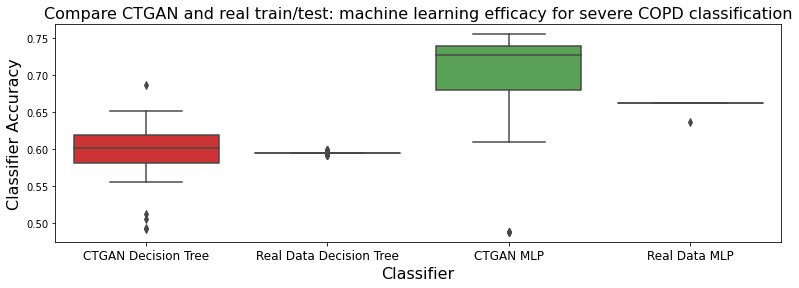

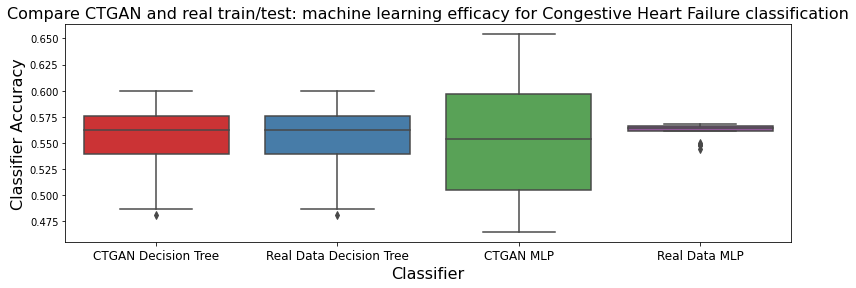

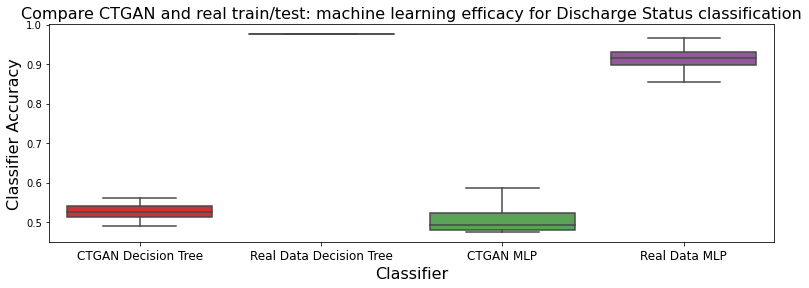

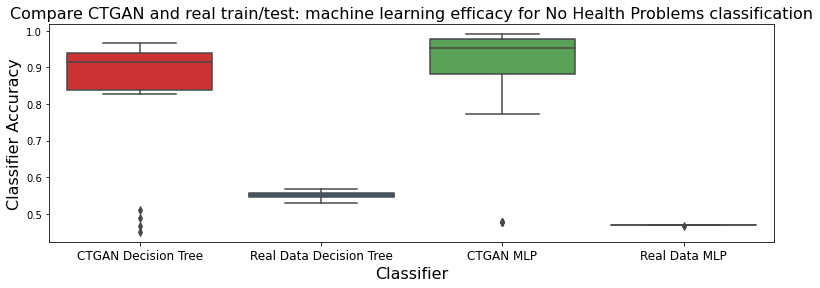

In [211]:
plot_comparison_boxplots(df_CTGAN_eval, 'COPD_severe', 'severe COPD')
plot_comparison_boxplots(df_CTGAN_eval, 'CHF', 'Congestive Heart Failure')
plot_comparison_boxplots(df_CTGAN_eval, 'dischargestatus', 'Discharge Status')
plot_comparison_boxplots(df_CTGAN_eval, 'NoHealthProblems', 'No Health Problems')
